In [1]:
import collections
import functools
import itertools
import math
import os

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec, ticker
%matplotlib inline

import pandas as pd

import numpy as np

import seaborn as sns
sns.set_style('whitegrid')
colors = sns.color_palette()

import scipy
from scipy.interpolate import interp1d

import statsmodels.api as sm

import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

from IPython.display import Image

In [2]:
class LinearFit(object):

    def __init__(self, x, y, fit):
        self.x = x
        self.X = sm.add_constant(x)
        self.y = y
        self.fit = fit

        self.b = fit.params
        self.y_intercept, self.slope = fit.params
        self.x_intercept = -self.y_intercept / self.slope

        self.xm = np.mean(x)
        self.Sxx = np.sum(np.power(self.x - self.xm, 2))
        self.ym = np.mean(y)
        self.n = fit.nobs
        self.dof = fit.df_resid
        self.rsquared = fit.rsquared
        self.stddev = np.sqrt(fit.ssr / fit.df_resid)

    def yp(self, xp):
        """Calculates line over given x range."""
        return np.dot(sm.add_constant(xp), self.b)

    def tstar(self, alpha):
        """Statistical t-test for confidence intervals."""
        return scipy.stats.distributions.t.ppf(1.0 - alpha / 2.0, self.dof)

    def confidence_interval(self, xp=None, yp=None, alpha=0.05):
        """Calculates confidence interval for either x or y values."""
        if not (xp is None) ^ (yp is None):
            raise ValueError('Only one of [xp, yp] must be specified.')

        if xp is not None:
            return self._y_ci(xp, alpha=alpha)
        if yp is not None:
            return self._x_ci(yp, alpha=alpha)

    def prediction_interval(self, xp=None, yp=None, alpha=0.05):
        """Calculates prediction interval for either x or y values."""
        if not (xp is None) ^ (yp is None):
            raise ValueError('Only one of [xp, yp] must be specified.')

        if xp is not None:
            return self._y_pi(xp, alpha=alpha)
        if yp is not None:
            return self._x_pi(yp, alpha=alpha)

    def plot_fit(self, xp, axis, alpha=0.05, ci=True):
        """Plots the fit over given x range."""
        yp = self.yp(xp)
        
        if ci:
            ci = self.confidence_interval(xp, alpha=alpha)
            pi = self.prediction_interval(xp, alpha=alpha)
            axis.fill_between(xp, yp - pi, yp + pi, color='k', alpha=0.1)
            axis.fill_between(xp, yp - ci, yp + ci, color='k', alpha=0.2)
        axis.plot(xp, yp, c='k', ls=':')

    def _y_ci(self, xp, alpha=0.05):
        return (self.tstar(alpha) * self.stddev
                * np.sqrt((1. / self.n) + (np.power(xp - self.xm, 2) / self.Sxx)))

    def _y_pi(self, xp, alpha=0.05):
        return (self.tstar(alpha) * self.stddev
                * np.sqrt(1. + (1. / self.n) + (np.power(xp - self.xm, 2) / self.Sxx)))

    def _x_ci(self, yp, alpha=0.05):
        """Inverse regression, after Sec 3.2 from Draper & Smith 1998."""
        xp = (yp - self.b[0]) / self.b[1]
        dx = xp - self.xm
        ts = self.tstar(alpha) * self.stddev
        b1 = self.b[1]
        g = (ts / b1) ** 2 / self.Sxx

        left = dx * g
        denom = (1. - g)
        right = (ts / b1) * np.sqrt(dx ** 2 / self.Sxx + denom / self.n)

        return np.array([(left - right) / denom, (left + right) / denom])

    def _x_pi(self, yp, alpha=0.05):
        """Inverse regression, after Sec 3.2 from Draper & Smith 1998."""
        xp = (yp - self.b[0]) / self.b[1]
        dx = xp - self.xm
        ts = self.tstar(alpha) * self.stddev
        b1 = self.b[1]
        g = (ts / b1) ** 2 / self.Sxx

        left = dx * g
        denom = (1. - g)
        right = (ts / b1) * np.sqrt(dx ** 2 / self.Sxx + denom / self.n + denom)

        return np.array([(left - right) / denom, (left + right) / denom])

# Cluster Data
Split into 2 clusters, select the cluster with higher average threshold

In [3]:
data = pd.read_csv('../data/interim/photoemission.csv')
data['logQE'] = np.log10(data.QE)
data['sqrtQE'] = np.sqrt(data.QE)
data['QE3'] = np.power(data.QE, 1. / 3.)

In [4]:
X = data[['Eth', 'logQE']].values
n_samples, n_features = X.shape
sX = scale(X)

# perform k-means clustering
estimator = KMeans(n_clusters=2)
estimator.fit(sX)
Z = estimator.predict(sX)

data['z'] = Z

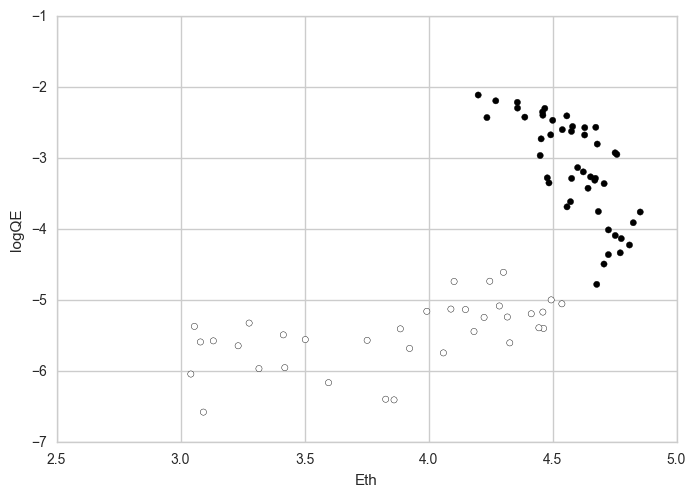

In [5]:
data.plot(x='Eth', y='logQE', kind='scatter', c=Z)

In [6]:
cluster = data.groupby(['z']).mean().sort_values(by='Eth', ascending=False).index[0]

In [7]:
df = data[data.z==cluster].copy()
df['sqrtQE'] = np.sqrt(df.QE)

In [8]:
xerr = np.array([df.err_minus.values, df.err_plus.values])
xerr.shape

(2, 46)

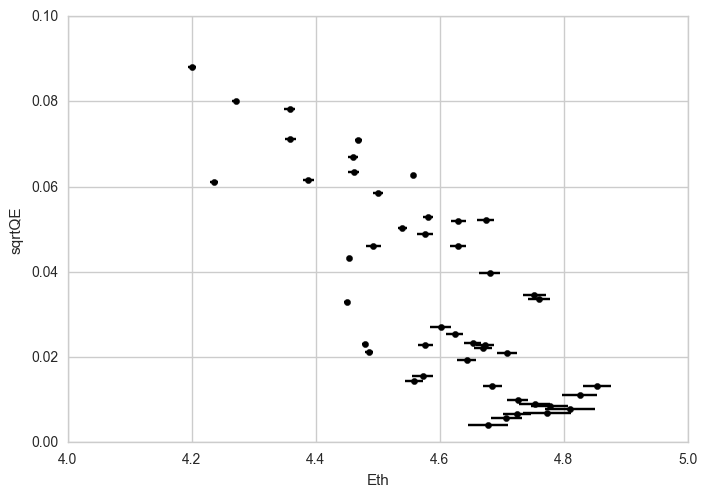

In [9]:
df.plot(x='Eth', y='sqrtQE', kind='scatter', xerr=xerr, c='k', ylim=(0, 0.1), xlim=(4, 5))

In [10]:
def iterative_fit(data, xcol, ycol, n_iterations=2):
    condition = None

    for n in range(n_iterations):
        if condition is not None:
            df = data[condition]
        else:
            df = data

        x = df[xcol].values
        X = sm.add_constant(x)
        y = df[ycol].values

        model = sm.OLS(y, X)
        results = model.fit()
        fit = LinearFit(x, y, results)

        condition = data[ycol] > (fit.yp(xp=data[xcol]) + fit.confidence_interval(xp=data[xcol]))

    return fit

In [11]:
fit = iterative_fit(df, 'Eth', 'QE3', n_iterations=2)

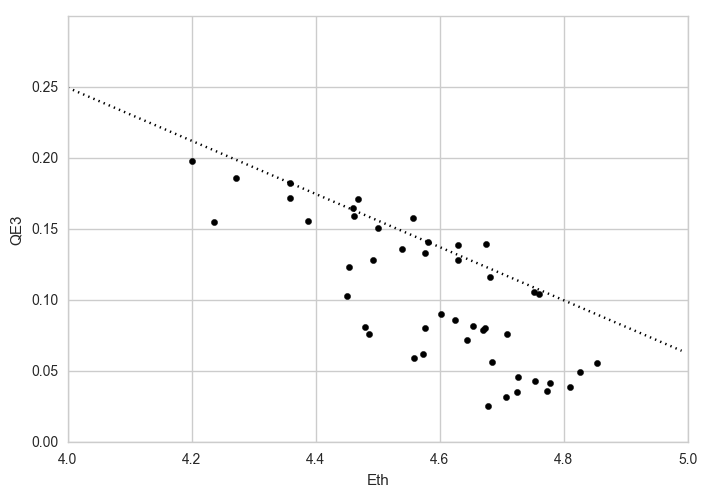

In [12]:
fig, ax = plt.subplots(1, 1)
df.plot(x='Eth', y='QE3', kind='scatter', c='k', ylim=(0, 0.3), xlim=(4, 5), ax=ax)
fit.plot_fit(np.arange(4, 5, 0.01), axis=ax, ci=False)